### 기울기 소실과 기울기 폭발의 원인

In [1]:
import numpy as np
a = np.array([[2.,3.,-1.,4.,-5.],
              [1.,3.,-7.,2.,-6.]])
a *= 2
norm = np.sqrt(np.sum(a**2)) / 2 # L2-norm
print(norm)

12.409673645990857


[1.9660860237332416, 2.116212097993695, 2.4170358261190943, 2.5274014203977324, 2.590490440137253, 2.617506816392389, 2.630889453156624, 2.6366768407555536, 2.6391731704025707, 2.6400037331007913, 2.6400722641483294, 2.6397691239325582, 2.639292140968135, 2.638731689818709, 2.638131890953925, 2.637513377982821, 2.6368860706063892, 2.636254653493981, 2.6356213645439577, 2.6349872649210995]


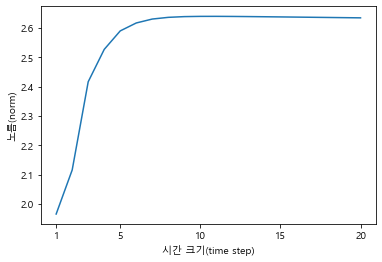

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H)) # 1로 초기화
# norm = np.sqrt(np.sum(dh**2)) / N # L2-norm을 배치수로 나누면 배치 하나 당 스칼라 값
# print(norm) # 1.224744871391589

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

# Wh = np.random.randn(H, H)  # 평균:0, 표준편차:1
# # print(Wh) # seed=3 고정이기 때문에 매번 같은 난수 추출
# # print(Wh.T)
# dh = np.dot(dh, Wh.T)
# print(dh) # 항상 일정 =
# norm = np.sqrt(np.sum(dh**2)) / N
# print(norm) # 2.4684068094579303 => 평균0, std1보다는 노름이 더 큼. 
Wh = np.random.randn(H, H) * 0.7965 # => 기울기가 갈수록 x축에 거의 평행하는 것을 알 수 있음
# Wh = np.random.randn(H, H) * 0.5 # 평균 0, std/2로 계산해보기 => 기울기 소실
# Wh = np.random.randn(H, H) # 평균0, std1 => 기울기 폭발
'''기울기가 소실된 건 막을 수 없지만 폭발하는 것은 특정한 값을 나누어주면 폭발을 막을 수 있다!
            => 기울기 클리핑(gradients clipping)~~~~
            넘친 만큼 나누기 하여 기울기를 깎음 '''
# norm = np.sqrt(np.sum(Wh**2)) / H 
# print(norm)

norm_list = []
for t in range(T): # 평균0, std1로 난수 추출했을 때 계산 결과가 기하급수적으로 커지는지 작아지는지 확인
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list) # [2.4684068094579303, 3.3357049741610365, 4.783279375373182 ... 점점 커짐 => 기울기 폭발

# # 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 기울기 폭발 대책

In [20]:
import numpy as np

np.random.seed(3)
# dh_next = np.random.rand(3, 3) * 5
dh_next = np.array([[2.,2.,2.], # 뒤에서 날아온 미분값이 이라고 가정 
               [3.,3.,3.],
               [4.,4.,4.]])
dh_next = dh_next * 2
# norm = np.sqrt(np.sum(dh_next**2)) / 3
# print(norm) # 3.109126351029605 => 2,3,4의 중간이며 max_norm이라는 threshold는 넘치지 않음..

max_norm = 5.0 # threshold. 최대한 L2-norm이 0.5를 넘지 않도록~

def clip_grads(grads, max_norm):
    total_norm = 0
    total_norm += np.sum(grads ** 2) # 그래디언트가 여러개라고 가정했을 때
    total_norm = np.sqrt(total_norm) / 3

    print(total_norm)
    rate = max_norm / (total_norm + 1e-6) # 노름끼리의 평균
    print(rate)
    if rate < 1:
        grads *= rate
        
    total_norm = 0
    total_norm += np.sum(grads ** 2)
    total_norm = np.sqrt(total_norm) / 3 # 원래 노름이 6.21825270205921 이었는데 4.999999195915728로 절대 0.5를 넘지 않음~
    print(total_norm)

print('before:', dh_next.flatten())
clip_grads(dh_next, max_norm)
print('after:', dh_next.flatten())

before: [4. 4. 4. 6. 6. 6. 8. 8. 8.]
6.21825270205921
0.804084271818022
4.999999195915728
after: [3.21633709 3.21633709 3.21633709 4.82450563 4.82450563 4.82450563
 6.43267417 6.43267417 6.43267417]


In [22]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    print(total_norm)
    rate = max_norm / (total_norm + 1e-6)
    print(rate)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    print(total_norm)


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [2.59252447 4.15101197 2.83525082 6.93137918 4.40453718 1.56867738
 5.44649018 7.80314765 3.06363532]
24.86242625109438
0.2011066719071008
4.9999997988933265
after: [0.52137397 0.8347962  0.57018786 1.3939466  0.88578181 0.31547149
 1.09532551 1.56926505 0.6161175 ]
